In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import random, os, numpy as np, pandas as pd, torch, torch.nn as nn
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
import copy, warnings, pytorch_lightning as pl
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
PATH_TO_CSV = Path("/content/drive/MyDrive/data_clean/processed_data_with_features.csv")
df = pd.read_csv(PATH_TO_CSV)

In [ ]:
WINDOW = 20
SPLIT_RATIO = 0.8

# selected features for modeling
FEATURES = [
    "DAY_OF_THE_WEEK", "HOUR_OF_DAY", "LOG_RETURN",
    "vol_20", "vol_60",
    "sr_20",
    "mean_20",
    "zscore_20", "zscore_60",
    "log_momentum_20", "log_momentum_60",
    "bb_upper_20", "bb_lower_20",
    "mdd_20",
    "ema_12", "ema_26",
    "macd", "macd_signal", "macd_hist"
]

In [ ]:
# Sharpe ratio
def sharpe_ratio(ret, rf=0.0, annualisation=252):
    excess = ret - rf
    return np.sqrt(annualisation) * excess.mean() / (excess.std(ddof=1) + 1e-9)

# Mean squared error
def mse(a, b):
    return np.mean((a - b) ** 2)

# Mean absolute error
def mae(a, b):
    return np.mean(np.abs(a - b))


In [ ]:
class HFData:
    def __init__(self, csv_path: Path, window: int = 20, features: list[str] = FEATURES):
        self.csv_path = csv_path
        self.window = window
        self.features = features
        self._prep()

    def _prep(self):
        df = pd.read_csv(self.csv_path)
        df["DATETIME"] = pd.to_datetime(df["DATETIME"])
        df["DAY_OF_THE_WEEK"] = df["DATETIME"].dt.dayofweek
        df = df.sort_values(["SYMBOL", "DATETIME"]).reset_index(drop=True)
        df = df.dropna(subset=self.features + ["LOG_RETURN"])
        self.df = df.reset_index(drop=True)
        self._build_sequences()
        self._standardise()

    def _build_sequences(self):
        # building rolling windows of features and corresponding targets
        X, y, sym = [], [], []
        for symbol, grp in self.df.groupby("SYMBOL"):
            gnp = grp[self.features].values
            yv = grp["LOG_RETURN"].values
            for i in range(len(grp) - self.window):
                X.append(gnp[i:i + self.window])
                y.append(yv[i + self.window])
                sym.append(symbol)
        self.X = np.stack(X)
        self.y = np.array(y)
        self.symbols = np.array(sym)

    def _standardise(self):
        # standardizing features and target
        X = np.nan_to_num(self.X)
        mu = X.mean((0, 1), keepdims=True)
        sd = X.std((0, 1), keepdims=True) + 1e-8
        ymu = self.y.mean()
        ysd = self.y.std() + 1e-8
        self.X = (X - mu) / sd
        self.y = (self.y - ymu) / ysd
        self.scalers = dict(X_mu=mu, X_sd=sd, y_mu=ymu, y_sd=ysd)

    def train_test(self, ratio=SPLIT_RATIO):
        # hold-out split
        cut = int(len(self.X) * ratio)
        return (self.X[:cut], self.y[:cut]), (self.X[cut:], self.y[cut:])

    def folds(self, n_splits=5):
        # CV indices
        tscv = TimeSeriesSplit(n_splits=n_splits)
        return list(tscv.split(self.X))

In [ ]:
data = HFData(PATH_TO_CSV, WINDOW, FEATURES)
(X_train, y_train), (X_test, y_test) = data.train_test()

print("Shapes:", X_train.shape, X_test.shape)

# to create PyTorch DataLoader from arrays
def make_loader(X, y, batch=64, shuffle=False):
    tens = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    ds = torch.utils.data.TensorDataset(*tens)
    return torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, shuffle=True)
test_loader  = make_loader(X_test, y_test)

folds = data.folds(n_splits=5)

Shapes: (288390, 20, 19) (72098, 20, 19)


In [ ]:
# weight initialization for our layesr
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

# evaluate model predictions
def metric_pack(y_p, y_t):
    # rescaling predictions and targets
    y_p_r = y_p * data.scalers["y_sd"] + data.scalers["y_mu"]
    y_t_r = y_t * data.scalers["y_sd"] + data.scalers["y_mu"]

    return dict(
        mse = mse(y_t, y_p),
        mae = mae(y_t, y_p),
        sharpe = sharpe_ratio(y_p_r - y_t_r),
        corr = np.corrcoef(y_t, y_p)[0, 1],
        acc = np.mean((y_p > 0) == (y_t > 0))
    )

def loader_idx(idx, batch=256, shuf=False):
    Xt, yt = data.X[idx], data.y[idx]
    ds = torch.utils.data.TensorDataset(
        torch.tensor(Xt, dtype=torch.float32),
        torch.tensor(yt, dtype=torch.float32).unsqueeze(1)
    )
    return torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=shuf)

In [ ]:
class ReturnLSTM(nn.Module):
    def __init__(self, inp, hidden=64, layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=inp,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )
        self.apply(init_weights)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.head(h[-1])

In [ ]:
# Set random seed for reproducibility
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
import copy

In [ ]:
epoch_logs, fold_logs = [], []

betas = [1e-4, 5e-4, 1e-3, 3e-3, 1e-2]
epochs = 25
patience = 3
seeds = [0]

best_beta, best_sharpe = None, -1e9
saved_states = None

for beta in betas:
    fold_states, fold_sharpes = [], []
    for sd in seeds:
        set_seed(sd)
        for k, (tr, val) in enumerate(data.folds(n_splits=5)):
            mdl = ReturnLSTM(data.X.shape[2], hidden=64).to(device)
            opt = torch.optim.AdamW(mdl.parameters(), lr=3e-4, weight_decay=1e-4)
            sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=1)
            loss_fn = nn.SmoothL1Loss(beta=beta)

            best_state, best_shp, bad = None, -1e9, 0
            train_dl, val_dl = loader_idx(tr, shuf=True), loader_idx(val)

            for ep in range(1, epochs + 1):
                # Training
                mdl.train()
                mse_sum, n = 0.0, 0
                for xb, yb in train_dl:
                    xb, yb = xb.to(device), yb.to(device)
                    opt.zero_grad()
                    out = mdl(xb)
                    loss = loss_fn(out, yb)
                    loss.backward()
                    nn.utils.clip_grad_norm_(mdl.parameters(), 1.0)
                    opt.step()

                    mse_sum += ((out.detach() - yb) ** 2).sum().item()
                    n += yb.size(0)
                train_mse = mse_sum / n

                # Validation
                mdl.eval()
                vp, vt = [], []
                with torch.no_grad():
                    for xb, yb in val_dl:
                        vp.append(mdl(xb.to(device)).cpu().numpy())
                        vt.append(yb.cpu().numpy())
                vp, vt = np.concatenate(vp).ravel(), np.concatenate(vt).ravel()
                val_metrics = metric_pack(vp, vt)

                # Scheduler step
                sched.step(val_metrics["mse"])

                # Log epoch metrics
                epoch_logs.append({
                    "beta": beta,
                    "fold": k,
                    "epoch": ep,
                    "train_mse": train_mse,
                    "val_mse": val_metrics["mse"]
                })

                # Early stopping
                if val_metrics["sharpe"] > best_shp:
                    best_shp = val_metrics["sharpe"]
                    best_state = copy.deepcopy(mdl.state_dict())
                    bad = 0
                else:
                    bad += 1
                if bad == patience:
                    break

            fold_states.append(best_state)
            fold_sharpes.append(best_shp)
            fold_logs.append({
                "beta": beta,
                "fold": k,
                "sharpe": best_shp,
                "mse": val_metrics["mse"]
            })

    cv_shp = np.mean(fold_sharpes)
    if cv_shp > best_sharpe:
        best_beta, best_sharpe, saved_states = beta, cv_shp, fold_states

print(f"Chosen β = {best_beta}, CV Sharpe = {best_sharpe:.4f}")

Chosen β = 0.0001, CV Sharpe = 0.3651


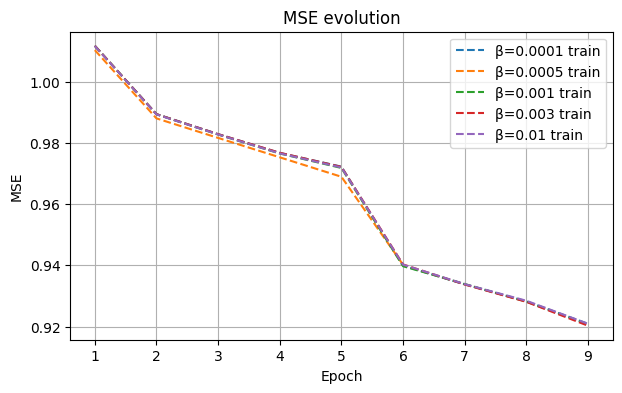

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

hist_df = pd.DataFrame(epoch_logs)
sharpe_df = pd.DataFrame(fold_logs)

plt.figure(figsize=(7, 4))
for b in sorted(hist_df.beta.unique()):
    grp = hist_df[hist_df.beta == b].groupby("epoch")[["train_mse"]].mean()
    plt.plot(grp.index, grp.train_mse, "--", label=f"β={b:g} train")

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Evolution")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
test_ds = torch.utils.data.TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=512)

pred_matrix = []
for st in saved_states:
    # Infer hidden size from saved state shape
    hdim = st["lstm.weight_ih_l0"].shape[0] // 4
    mdl = ReturnLSTM(data.X.shape[2], hidden=hdim).to(device)
    mdl.load_state_dict(st)
    mdl.eval()

    preds = []
    with torch.no_grad():
        for xb, _ in test_dl:
            preds.append(mdl(xb.to(device)).cpu().numpy())
    pred_matrix.append(np.concatenate(preds).ravel())

pred_matrix = np.vstack(pred_matrix)
ens_pred = pred_matrix.mean(axis=0)

hold_metrics = metric_pack(ens_pred, y_test)
print("Hold-out metrics:", hold_metrics)

Hold-out metrics: {'mse': np.float64(0.8704416308798185), 'mae': np.float64(0.5692041568582342), 'sharpe': np.float64(0.38028243388329963), 'corr': np.float64(0.20183851978973957), 'acc': np.float64(0.533523814807623)}


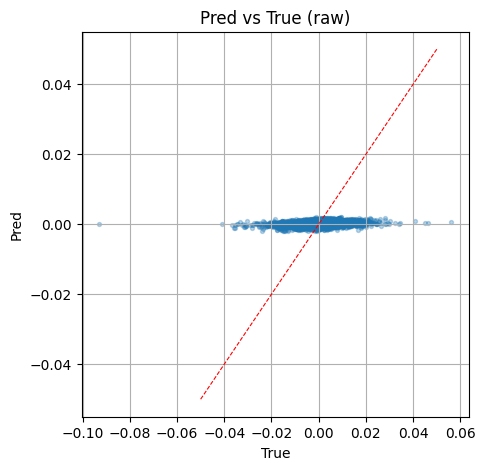

In [ ]:
cut = int(len(data.X) * SPLIT_RATIO)
symbols_test = data.symbols[cut:]

ysd, ymu = data.scalers["y_sd"], data.scalers["y_mu"]
y_pred_raw = ens_pred * ysd + ymu
y_true_raw = y_test * ysd + ymu

df_res = pd.DataFrame({
    "symbol": symbols_test,
    "true_s": y_test,
    "pred_s": ens_pred,
    "true": y_true_raw,
    "pred": y_pred_raw,
    "err": y_pred_raw - y_true_raw
})

# scatter plot of raw predicted vs true returns
plt.figure(figsize=(5, 5))
plt.scatter(df_res.true, df_res.pred, alpha=0.3, s=8)
plt.plot([-0.05, 0.05], [-0.05, 0.05], "r--", lw=0.8)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Predicted vs True (raw)")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def _m(g):
    a, b = g.pred_s.values, g.true_s.values
    return pd.Series({
        "mse": mean_squared_error(b, a),
        "mae": mean_absolute_error(b, a),
        "corr": np.corrcoef(a, b)[0, 1] if np.std(b) > 0 else np.nan,
        "acc": np.mean((a > 0) == (b > 0)),
        "sharpe": sharpe_ratio(g.pred.values - g.true.values)
    })

per_sym = df_res.groupby("symbol").apply(_m).sort_values("corr", ascending=False)

print("Top 10 by correlation:\n", per_sym.head(10))
print("\nBottom 10 by correlation:\n", per_sym.tail(10))

Top 10 by correlation:
              mse       mae      corr       acc    sharpe
symbol                                                  
TXT     0.719196  0.529111  0.380912  0.576720  0.306114
ROST    0.925069  0.602700  0.378143  0.542328  0.521037
SYF     1.229989  0.656345  0.358248  0.560847  0.708339
SCHW    0.860746  0.568411  0.357847  0.535714  0.571557
TFC     0.749860  0.517388  0.350655  0.567460  1.175076
SLB     1.284096  0.668251  0.342863  0.535714  0.577750
UHS     0.649787  0.558997  0.325031  0.543651  0.454324
STT     0.948293  0.589039  0.322529  0.578042  0.785354
VMC     0.545223  0.490271  0.319226  0.543651  0.597897
WAB     0.574361  0.493390  0.317248  0.537037  0.960698

Bottom 10 by correlation:
               mse       mae      corr       acc    sharpe
symbol                                                   
T        0.741998  0.523589  0.090671  0.474868  0.410202
WEC      0.355780  0.407512  0.085392  0.518519  0.213178
TSLA     3.555592  1.237371  0.0

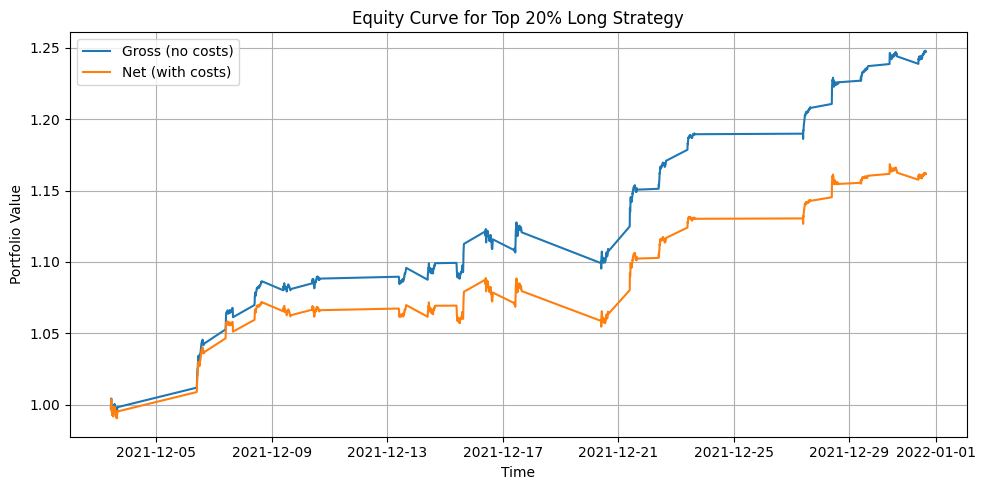

In [ ]:
cut = int(len(data.X) * SPLIT_RATIO)
test_idx = np.arange(cut, len(data.X))

if not hasattr(data, "datetimes"):
    dt_seq = []
    for _, grp in data.df.groupby("SYMBOL"):
        ts = grp["DATETIME"].values
        for i in range(len(grp) - data.window):
            dt_seq.append(ts[i + data.window])
    data.datetimes = np.array(dt_seq)

ysd, ymu = data.scalers["y_sd"], data.scalers["y_mu"]
y_pred_raw = ens_pred * ysd + ymu
y_true_raw = y_test * ysd + ymu

test_df = pd.DataFrame({
    "DATETIME": data.datetimes[test_idx],
    "SYMBOL": symbols_test,
    "y_pred": y_pred_raw,
    "LOG_RETURN": y_true_raw
}).sort_values("DATETIME").drop_duplicates(subset=["DATETIME", "SYMBOL"], keep="last")

# 80th percentile threshold per bar
q = 0.20
thresholds = test_df.groupby("DATETIME")["y_pred"].transform(lambda x: x.quantile(1 - q))
test_df["signal"] = (test_df["y_pred"] >= thresholds).astype(int)

# Strategy return = average return of long positions
def bar_log_return(grp):
    longs = grp.loc[grp["signal"] == 1, "LOG_RETURN"]
    return longs.mean() if len(longs) else 0.0

portf = test_df.groupby("DATETIME").apply(bar_log_return).rename("portfolio_logret")

# Turnover
signals_wide = test_df.pivot(index="DATETIME", columns="SYMBOL", values="signal").fillna(0)
turnover = signals_wide.diff().abs().sum(axis=1) / signals_wide.shape[1]

# Net performance
tc_rate = 0.001
portf_net = portf - turnover * tc_rate

# Cumulative performance
cum_gross = np.exp(portf.cumsum())
cum_net   = np.exp(portf_net.cumsum())

plt.figure(figsize=(10,5))
plt.plot(cum_gross, label="Gross (no costs)")
plt.plot(cum_net,   label="Net (with costs)")
plt.title("Equity Curve for Top 20% Long Strategy")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()